In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # visualization
!pip install seaborn as sns -q --upgrade pip # visualization with seaborn v0.11.1
import seaborn as sns # visualization
import missingno as msno # missing values pattern visualization
#set seed
import random
seed = 41
!pip install dabl -q --upgrade pip
import dabl # quick exploration and model assessment



import warnings # supress warnings
warnings.filterwarnings('ignore')

# set pandas display option
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)





# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Load the data 
train_df = pd.read_csv('../input/widsdatathon2021/TrainingWiDS2021.csv')
test_df = pd.read_csv('../input/widsdatathon2021/UnlabeledWiDS2021.csv')
data_dictionary_df = pd.read_csv("../input/widsdatathon2021/DataDictionaryWiDS2021.csv")

# Drop first column because it is identical to index
train_df.drop(columns = ['Unnamed: 0', 'encounter_id', 'hospital_id'], axis = 1, inplace = True)
test_df.drop(['Unnamed: 0', 'encounter_id', 'hospital_id'], axis = 1, inplace = True)

# display the dataset
train_df.head().style.set_caption('Sample of training data')

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,68.000000,22.732803,0,Caucasian,M,180.300000,Floor,Floor,92,admit,CTICU,0.541667,0,73.900000,2.300000,113.000000,502.010000,0,0,0.400000,31.000000,2.510000,nan,3.000000,6.000000,0.000000,4.000000,168.000000,118.000000,27.400000,0,40.000000,nan,nan,nan,nan,36.000000,134.000000,39.300000,nan,0,14.100000,46.000000,32.000000,68.000000,37.000000,68.000000,37.000000,119.000000,72.000000,66.000000,40.000000,89.000000,46.000000,89.000000,46.000000,34.000000,10.000000,100.000000,74.000000,122.000000,64.000000,131.000000,73.000000,131.000000,73.000000,39.900000,37.200000,nan,nan,68.000000,63.000000,68.000000,63.000000,119.000000,108.000000,nan,nan,86.000000,85.000000,86.000000,85.000000,26.000000,18.000000,100.000000,74.000000,nan,nan,131.000000,115.000000,131.000000,115.000000,39.500000,37.500000,2.300000,2.300000,0.400000,0.400000,31.000000,30.000000,8.500000,7.400000,2.510000,2.230000,168.000000,109.000000,19.000000,15.000000,8.900000,8.900000,27.400000,27.400000,nan,nan,1.300000,1.000000,233.000000,233.000000,4.000000,3.400000,136.000000,134.000000,14.100000,14.100000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [3]:
train_df.shape

(130157, 178)

In [4]:
# let's inspect the variable values
for var in train_df.columns:
    print(var, train_df[var].unique()[0:20], '\n')

age [68. 77. 25. 81. 19. 67. 59. 70. 45. 50. 72. 80. 48. 65. 78. 30. 46. 39.
 79. 58.] 

bmi [22.73280282 27.421875   31.95274882 22.63554823         nan 27.55561067
 57.45100248 25.70770213 28.25705249 27.3828125  38.18906706 23.38317807
 25.84571744 28.40892909 37.0102781  28.37610001 35.65998942 21.96376348
 29.50995926 26.01070291] 

elective_surgery [0 1] 

ethnicity ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown'] 

gender ['M' 'F' nan] 

height [180.3 160.  172.7 165.1 188.  190.5 165.  170.2 175.3 154.9 193.  167.6
 177.8 162.6 152.4 149.9 182.9 162.5 151.8 157.5] 

hospital_admit_source ['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other'] 

icu_admit_source ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan] 

icu_id [ 92 

h1_wbc_max [ nan 12.7  8.8  5.9 24.7 12.8  7.2 14.6  9.9 20.   9.2 17.4 15.6 32.7
 10.2  1.1 11.5  7.1 16.7 10. ] 

h1_wbc_min [    nan 12.7     8.8     5.9    24.7    12.8     7.2    14.6     9.9
 20.      9.2    17.4    15.6    32.7    10.2     1.0898 11.5     7.1
 16.7    10.    ] 

d1_arterial_pco2_max [nan 37. 43. 60. 47. 50. 35. 55. 40. 48. 34. 29. 53. 44. 41. 58. 33. 65.
 38. 28.] 

d1_arterial_pco2_min [nan 37. 27. 43. 33. 47. 29. 35. 40. 48. 26. 25. 38. 36. 50. 41. 28. 42.
 39. 74.] 

d1_arterial_ph_max [ nan 7.45 7.44 7.42 7.38 7.62 7.35 7.49 7.37 7.33 7.36 7.43 7.48 7.34
 7.53 7.39 7.4  7.29 7.32 7.46] 

d1_arterial_ph_min [ nan 7.45 7.34 7.42 7.38 6.99 7.35 7.26 7.17 7.37 7.33 7.36 6.89 7.47
 7.24 7.41 7.44 7.29 7.27 7.4 ] 

d1_arterial_po2_max [ nan  51. 337. 370.  89. 256. 141. 174.  77. 283. 104.  84.  85. 140.
 175. 167. 136. 373. 257. 119.] 

d1_arterial_po2_min [ nan  51. 102. 370.  89.  92. 141.  80.  77.  55. 104.  84.  85.  78.
 131. 167.  59.  46.  69.  67.] 

d1_

In [5]:
# make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in train_df.columns if train_df[var].dtype!='O' and var!='diabetes_mellitus' and train_df[var].nunique()<10]
continuous = [var for var in train_df.columns if train_df[var].dtype!='O' and var!='diabetes_mellitus' and var not in discrete]


# categorical
categorical = [var for var in train_df.columns if train_df[var].dtype=='O']

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))


There are 17 discrete variables
There are 154 continuous variables
There are 6 categorical variables


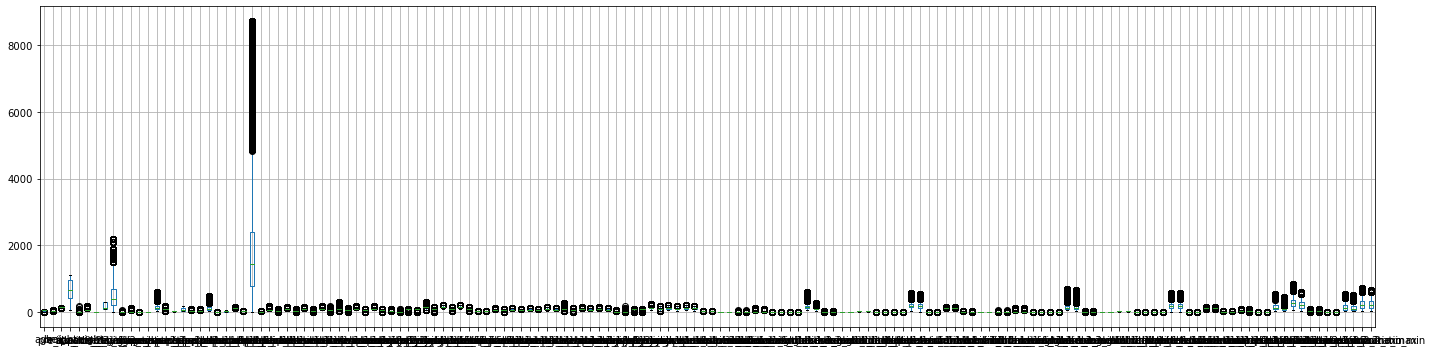

In [6]:
# outliers
fig = plt.figure(figsize=(20,5))
train_df[continuous].boxplot()
plt.tight_layout()
plt.show()

# Split the dataset 

In [7]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     train_df,
#     train_df.diabetes_mellitus,
#     test_size=0.33,
#     random_state=41,
#     stratify = train_df.diabetes_mellitus)

# X_train.shape, y_train.shape

If data are not missing at random, it is a good idea to replace missing observations by the mean / median / mode AND flag those missing observations as well with a Missing Indicator. A Missing Indicator is an additional binary variable, which indicates whether the data was missing for an observation (1) or not (0).

In [8]:
shallow_copy = train_df.copy()

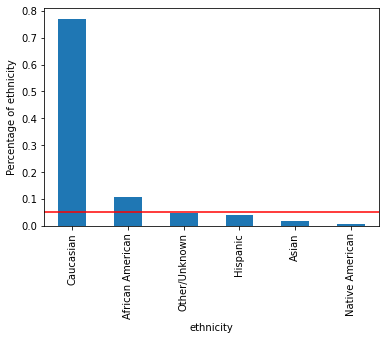

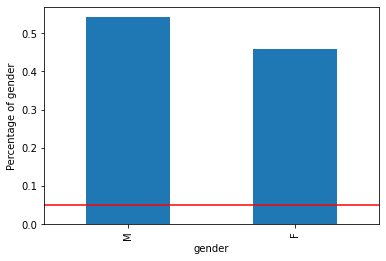

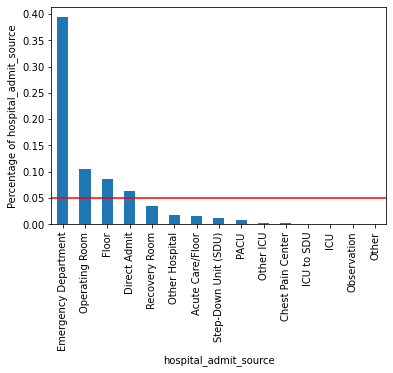

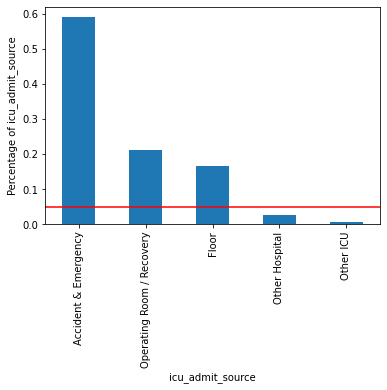

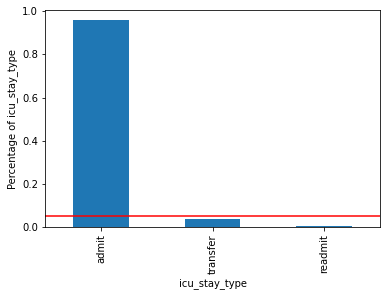

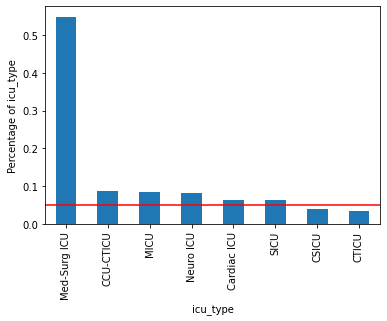

In [9]:
total_labels = len(shallow_copy)

# for each categorical variable
for col in shallow_copy.select_dtypes('object'):
    # calculate how many times the label is repeated in the whole dataset
    temp_df = pd.Series(shallow_copy[col].value_counts() / total_labels)

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel(f'Percentage of {col}')
    plt.show()

For each of the categorical variables, some labels appear in less than 5% of and many appear in less than 5% These are infrequent labels or Rare Values and could cause over-fitting.

In [10]:
shallow_copy.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,NaN,NaN,159.0,67.0,

# Reduce cardinality
Group rare labels into one category - apply to train, then will do again to test data when finalize the preprocess with the pipeline step.

Text(0, 0.5, 'Number of different categories')

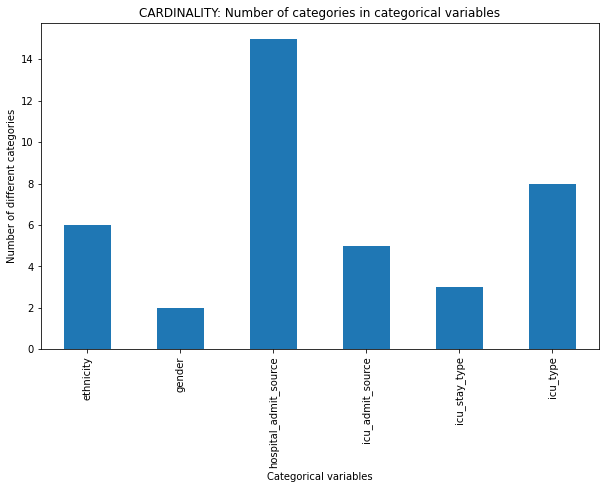

In [11]:
# plot number of categories per categorical variable

shallow_copy[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [12]:
# Number of unique classes in each object column
shallow_copy.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64

In [13]:
# I will replace all the labels that appear in less than 10%
# of the train_df by the label 'rare'


def group_rare_labels(df, var, tresh):

    total_obs = len(df)

    # first I calculate the % of obs for each category
    temp_df = pd.Series(df[var].value_counts() / total_obs)

    # now I create a dictionary to replace the rare labels with the
    # string 'rare' if they are present in less than 5% of obs

    grouping_dict = {
        k: ('rare' if k not in temp_df[temp_df >= tresh].index else k)
        for k in temp_df.index
    }

    # now I replace the rare categories
    tmp = df[var].map(grouping_dict)

    return tmp

In [14]:
# for each categorical variable
for col in shallow_copy.select_dtypes('object'):
    shallow_copy[col] = group_rare_labels(shallow_copy, col, 0.1)


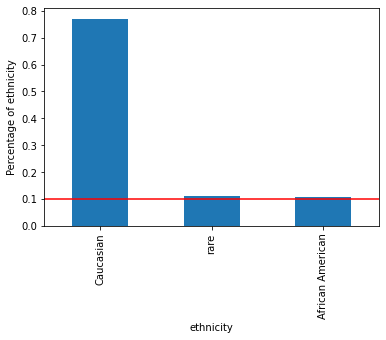

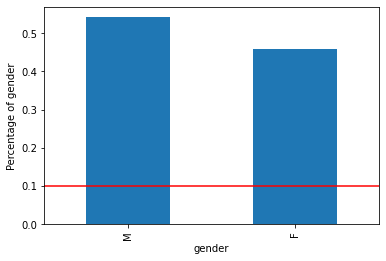

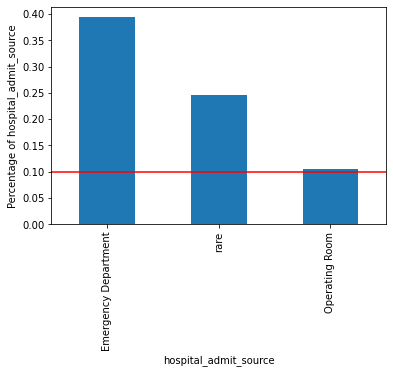

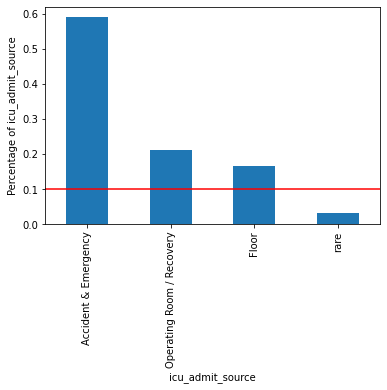

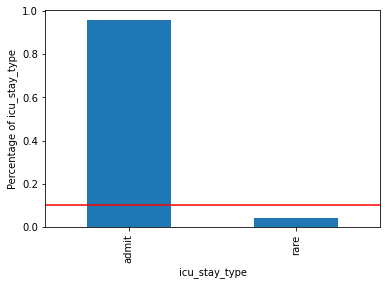

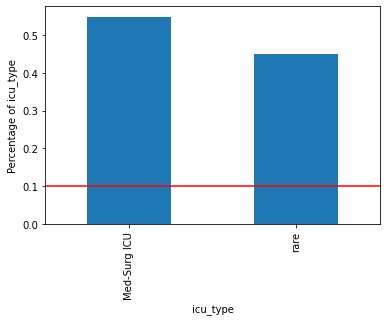

In [15]:
total_labels = len(shallow_copy)

# for each categorical variable
for col in shallow_copy.select_dtypes('object'):

    temp_df = pd.Series(shallow_copy[col].value_counts() / total_labels)

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.1, color='red')
    fig.set_ylabel(f'Percentage of {col}')
    plt.show()

In [16]:
# Number of unique classes in each object column
shallow_copy.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ethnicity                3
gender                   2
hospital_admit_source    3
icu_admit_source         4
icu_stay_type            2
icu_type                 2
dtype: int64

--------
<hr>

# Group missing values
Arbitrary value imputation for categorical variables
This is the most widely used method of missing data imputation for categorical variables. This method consists in treating missing data as an additional label or category of the variable. All the missing observations are grouped in the newly created label 'Missing'.

This is in essence, the equivalent of replacing by an arbitrary value for numerical variables.

The beauty of this technique resides on the fact that it does not assume anything about the fact that the data is missing. It is very well suited when the number of missing data is high.

Advantages
Easy to implement
Fast way of obtaining complete datasets
Can be integrated in production (during model deployment)
Captures the importance of "missingness" if there is one
No assumption made on the data
Limitations
If the number of NA is small, creating an additional category may cause trees to over-fit
For categorical variables this is the method of choice, as it treats missing values as a separate category, without making any assumption on the variable or the reasons why data could be missing. 

In [17]:
def missing_zero_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {df.index.name:'col_name', 0 : 'Missing Values', 1 : '% of Total Values'})
        mz_table['Data_type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0 ].sort_values(
        '% of Total Values', ascending=False)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table.reset_index()
missing = missing_zero_values_table(shallow_copy.select_dtypes('object'))
missing.style.background_gradient(cmap='Reds')

Your selected dataframe has 6 columns and 130157 Rows.
There are 4 columns that have missing values.


,index,Missing Values,% of Total Values,Data_type
0,hospital_admit_source,33198,25.510000,object
1,ethnicity,1587,1.220000,object
2,icu_admit_source,240,0.180000,object
3,gender,66,0.050000,object


In [18]:
shallow_copy['hospital_admit_source'].fillna('Missing', inplace=True)


<Figure size 360x504 with 0 Axes>

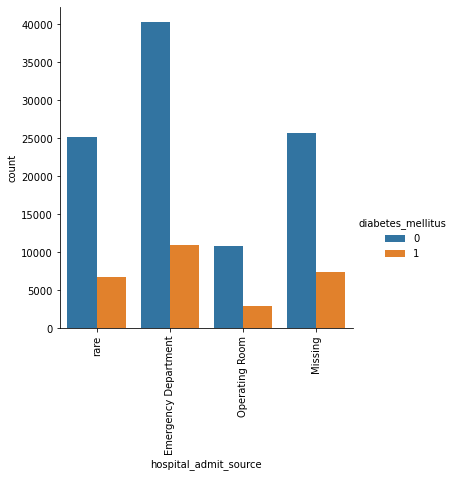

In [19]:
fig = plt.figure(figsize=(5, 7))
t = sns.catplot(data = shallow_copy, x = 'hospital_admit_source', hue = 'diabetes_mellitus', kind = 'count')
t.set_xticklabels(rotation=90)
plt.show()


<Figure size 360x504 with 0 Axes>

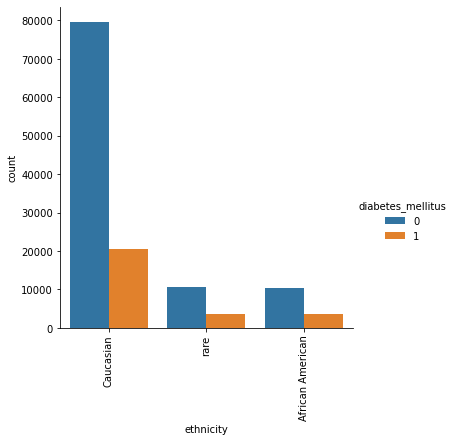

In [20]:
fig = plt.figure(figsize=(5, 7))
t = sns.catplot(data = shallow_copy, x = 'ethnicity', hue = 'diabetes_mellitus', kind = 'count')
t.set_xticklabels(rotation=90)
plt.show()

<Figure size 360x504 with 0 Axes>

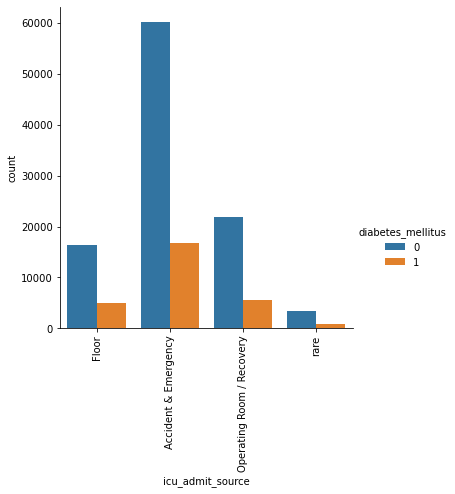

In [21]:
fig = plt.figure(figsize=(5, 7))
t = sns.catplot(data = shallow_copy, x = 'icu_admit_source', hue = 'diabetes_mellitus', kind = 'count')
t.set_xticklabels(rotation=90)
plt.show()

<Figure size 360x504 with 0 Axes>

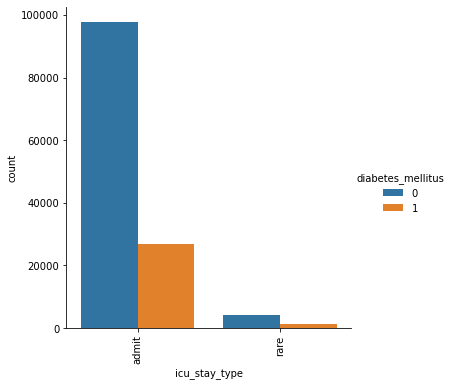

In [22]:
fig = plt.figure(figsize=(5, 7))
t = sns.catplot(data = shallow_copy, x = 'icu_stay_type', hue = 'diabetes_mellitus', kind = 'count')
t.set_xticklabels(rotation=90)
plt.show()


<Figure size 360x504 with 0 Axes>

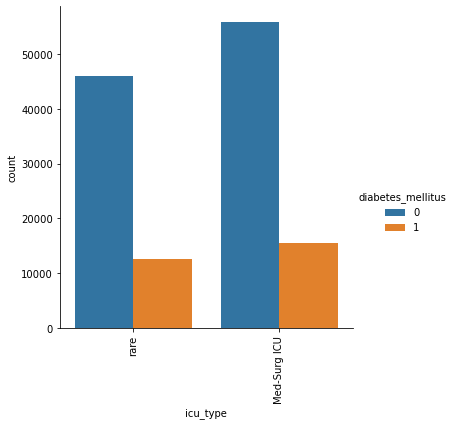

In [23]:

fig = plt.figure(figsize=(5, 7))
t = sns.catplot(data = shallow_copy, x = 'icu_type', hue = 'diabetes_mellitus', kind = 'count')
t.set_xticklabels(rotation=90)
plt.show()

<AxesSubplot:>

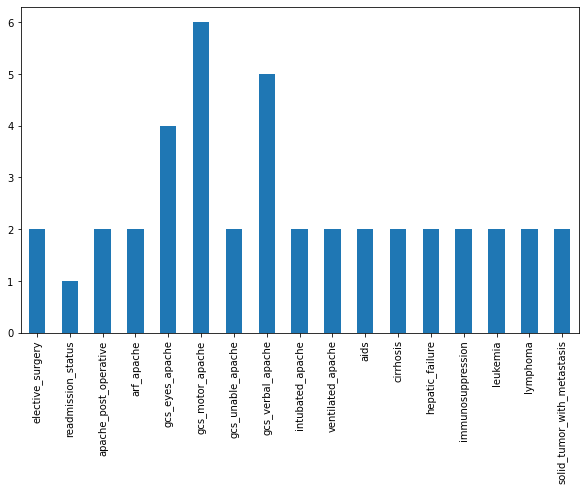

In [24]:
# plot number of categories per categorical variable

shallow_copy[discrete].nunique().plot.bar(figsize=(10,6))


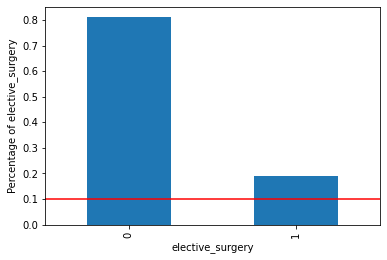

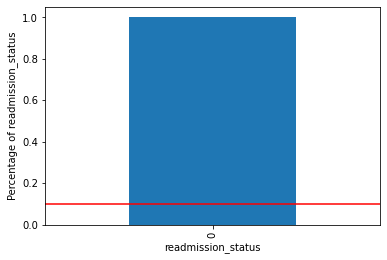

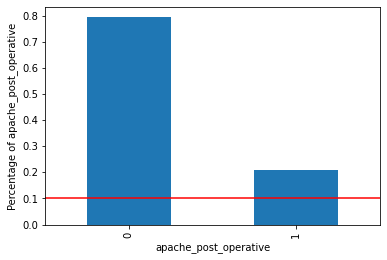

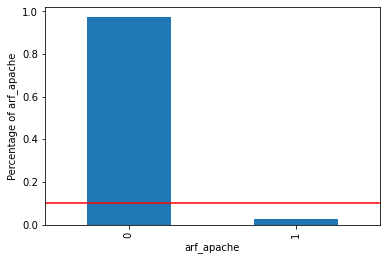

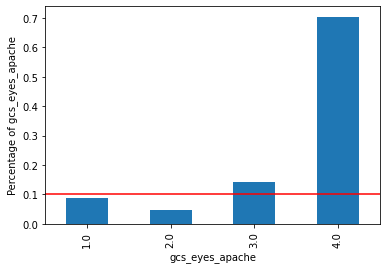

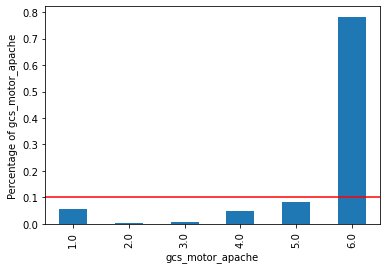

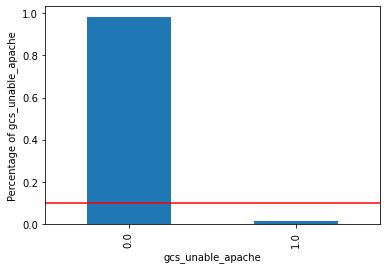

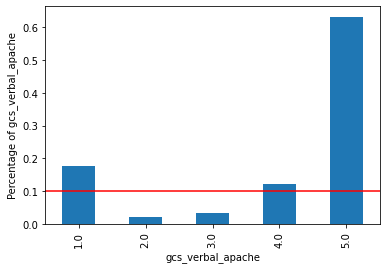

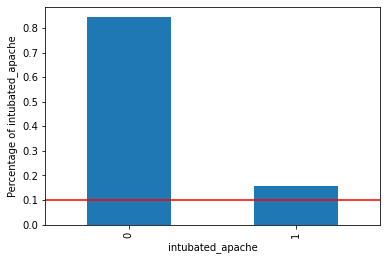

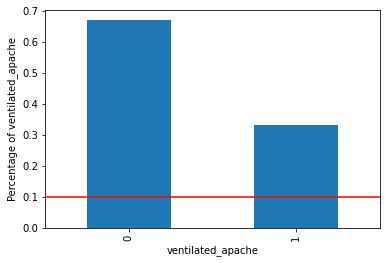

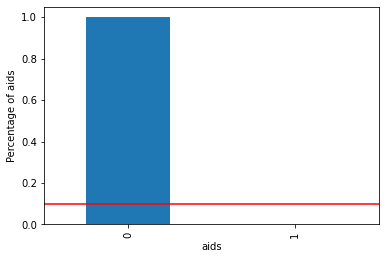

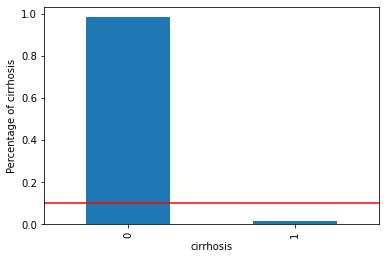

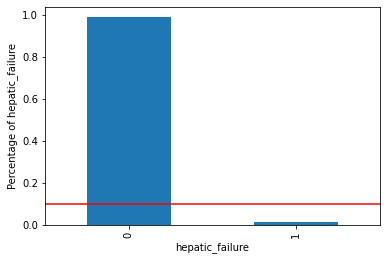

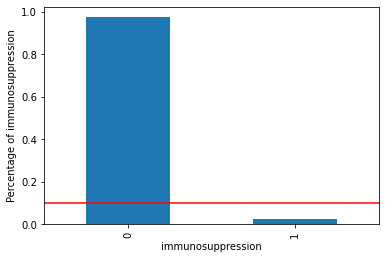

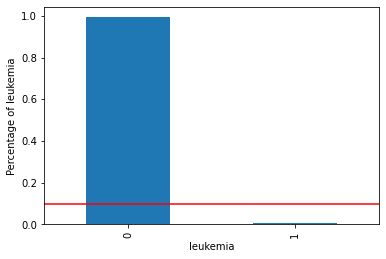

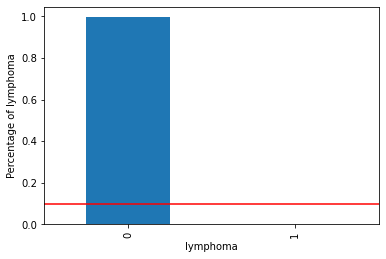

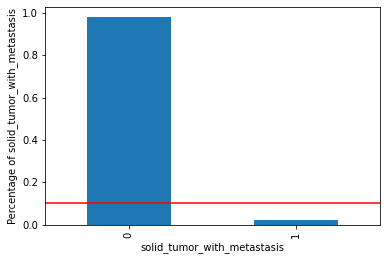

In [26]:
# for each categorical variable
for col in discrete:

    temp_df = pd.Series(shallow_copy[col].value_counts() / len(shallow_copy))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.1, color='red')
    fig.set_ylabel(f'Percentage of {col}')
    plt.show()

Convert all variables into categories that have a value of 2. remove vara that has 1 category and less than threshold. 

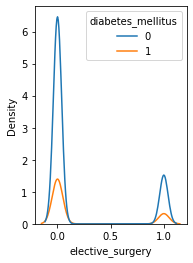

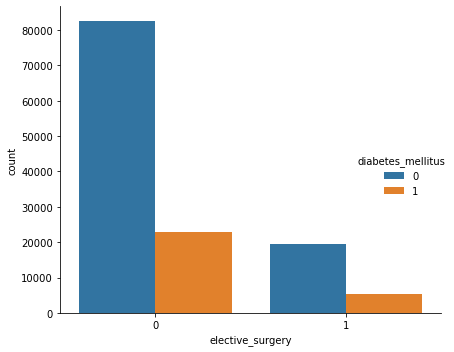

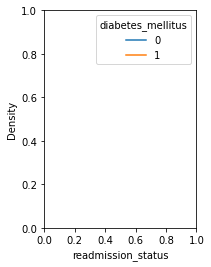

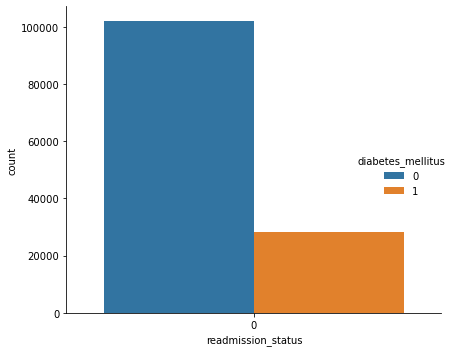

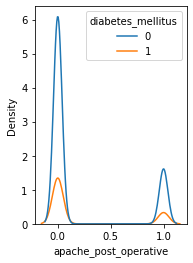

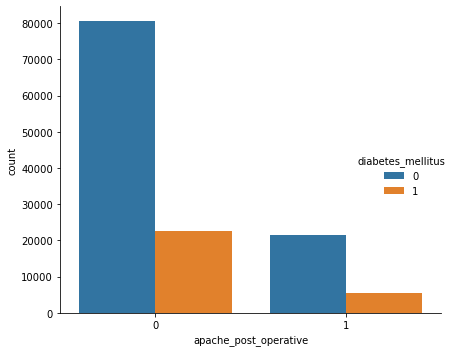

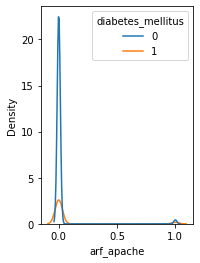

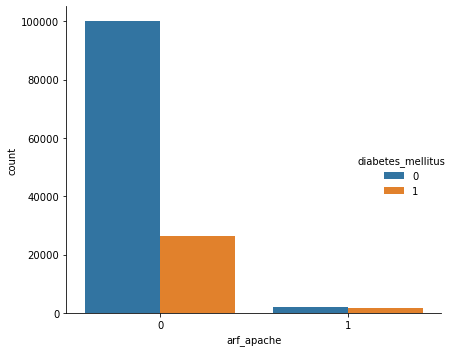

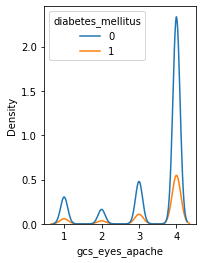

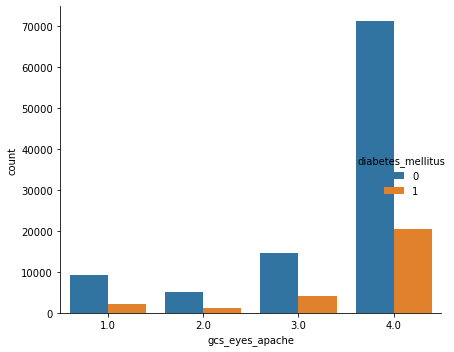

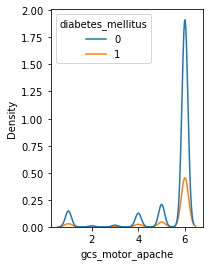

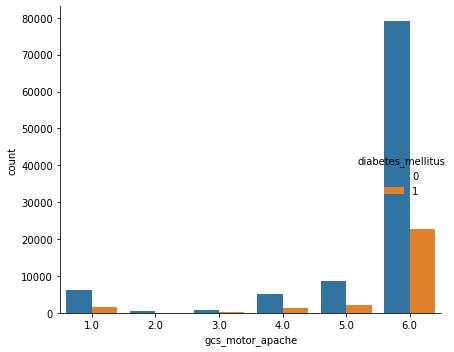

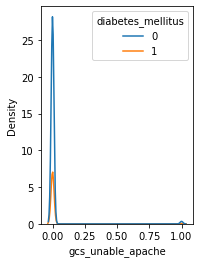

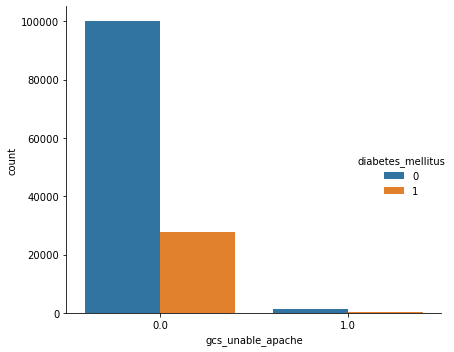

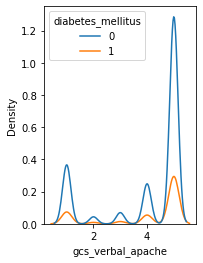

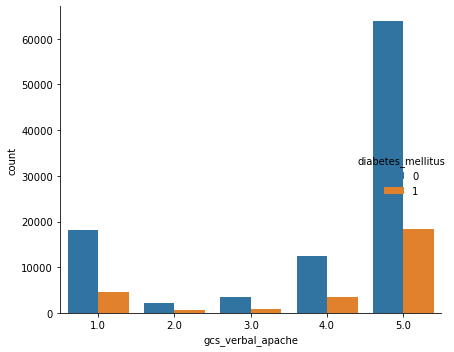

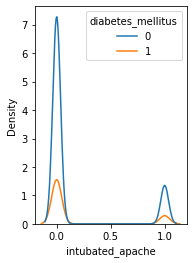

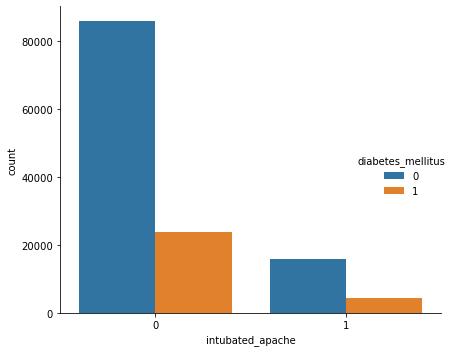

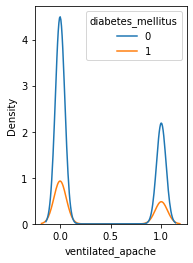

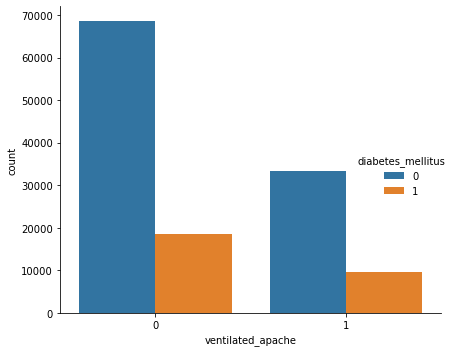

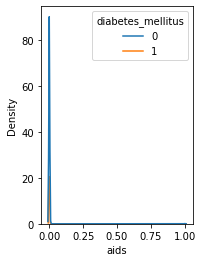

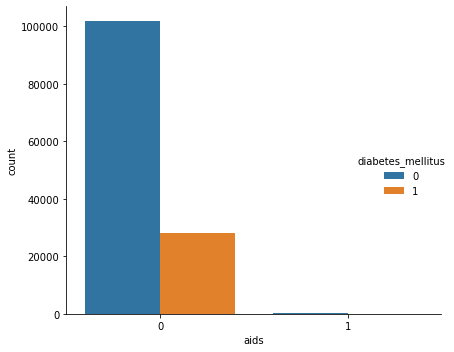

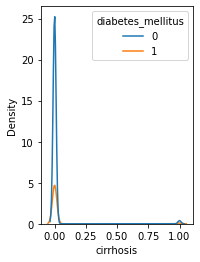

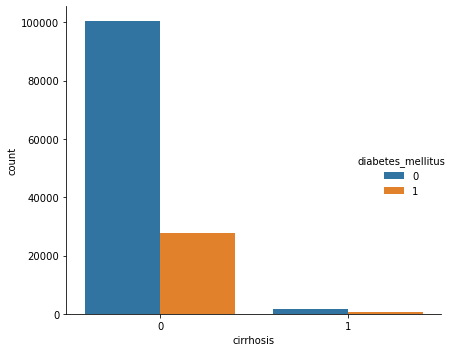

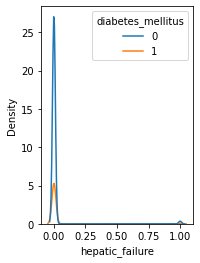

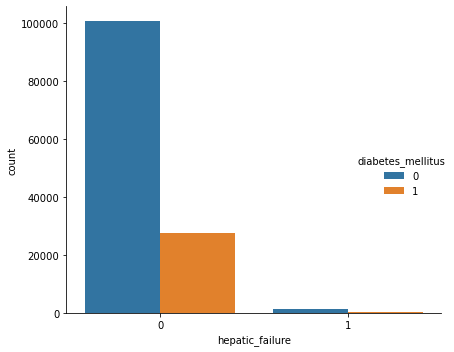

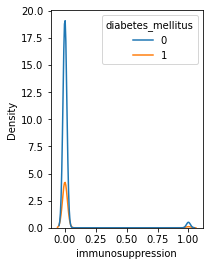

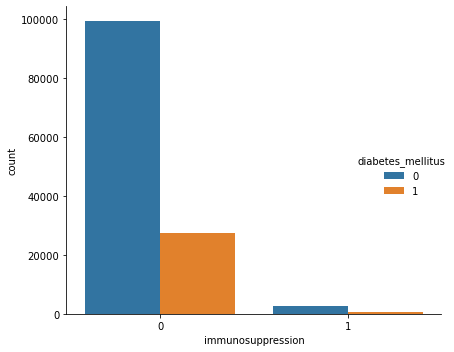

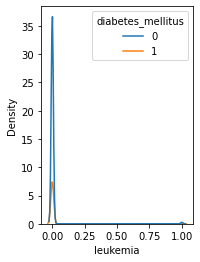

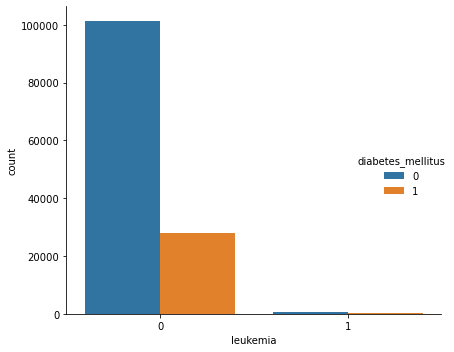

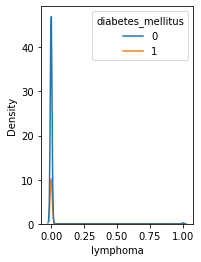

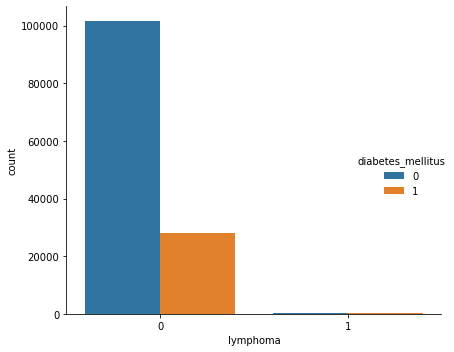

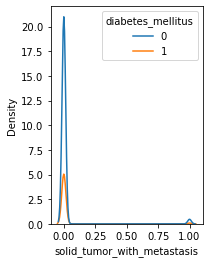

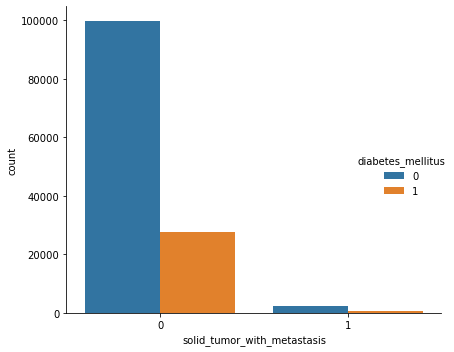

In [27]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution
plt.figure(2, figsize=(6,4))
c = 1
for var in discrete:
    plt.subplot(1, 2, 2)
    sns.kdeplot(data = shallow_copy, x = var, hue = 'diabetes_mellitus')
    
    plt.subplot(1, 2, 2)
    sns.catplot(data = shallow_copy, x = var, kind='count', hue = 'diabetes_mellitus')
  
    plt.tight_layout()
    plt.show()

In [28]:
co = train_df.copy()
co["gcs_motor_apache"].value_counts()

6.0    101818
5.0     10833
1.0      7549
4.0      6457
3.0       807
2.0       503
Name: gcs_motor_apache, dtype: int64

In [29]:
co['gcs_motor_apache'] = group_rare_labels(co, 'gcs_motor_apache', 0.1)

In [30]:
co["gcs_motor_apache"].value_counts().astype('category')

6.0     101818
rare     26149
Name: gcs_motor_apache, dtype: category
Categories (2, int64): [26149, 101818]

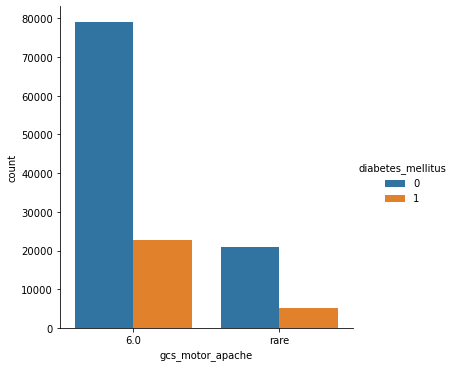

In [31]:
sns.catplot(data = co, x = 'gcs_motor_apache', hue = 'diabetes_mellitus', kind = 'count')

In [32]:
# for each categorical variable
for col in discrete:
    shallow_copy[col] = group_rare_labels(shallow_copy, col, 0.1)
    

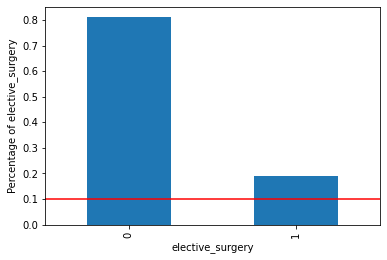

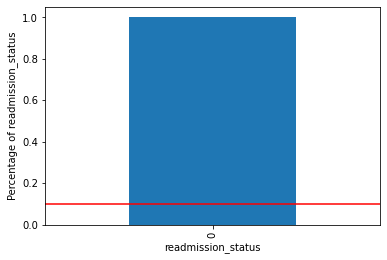

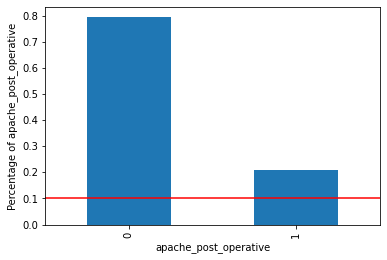

TypeError: Cannot cast Index to dtype int64

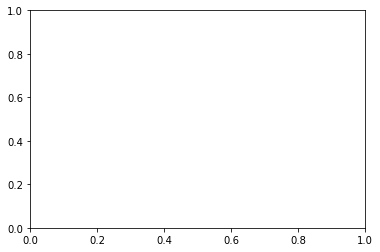

In [33]:
# plot number of categories per categorical variable
# for each categorical variable
for col in discrete:

    temp_df = pd.Series(shallow_copy[col].value_counts() / len(shallow_copy))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.1, color='red')
    fig.set_ylabel(f'Percentage of {col}')
    plt.show()

Drop `readmission_status`, `arf_apache`, 


-------
<hr>

# Transformation

In [ ]:
import scipy.stats as stats

from sklearn.preprocessing import FunctionTransformer, PowerTransformer

Let's select the numerical and positive variables in the dataset for this demonstration. As most of the transformations require the variables to be positive.

In [ ]:
X_train['age'].dtypes != 'O'

In [ ]:
# cols = []
# for col in X_train.columns:

#     if X_train[col].dtypes != 'object' and col != 'diabetes_mellitus':  # if the variable is numerical and not the target
        
#         if np.sum(np.where(X_train[col] <= 0, 1, 0)) == 0:  # if the variable is positive
        
#             cols.append(col)  # append variable to the list

# cols

In [ ]:

# # let's explore the distribution of the numerical variables
# fig = plt.figure(figsize = (20, 20))
# X_train[cols].hist(figsize=(20,20))
# plt.tight_layout()
# plt.show()

To visualise the distribution of the variables, we plot a histogram and a Q-Q plot. In the Q-Q pLots, if the variable is normally distributed, the values of the variable should fall in a 45 degree line when plotted against the theoretical quantiles. We discussed this extensively in Section 3 of this course.

In [ ]:
# # plot the histograms to have a quick look at the variable distribution
# # histogram and Q-Q plots

# def diagnostic_plots(df, variable):
    
#     # function to plot a histogram and a Q-Q plot
#     # side by side, for a certain variable
    
#     plt.figure(figsize=(15,6))
#     plt.subplot(1, 2, 1)
#     df[variable].hist(bins=30)

#     plt.subplot(1, 2, 2)
#     stats.probplot(df[variable], dist="norm", plot=plt)

#     plt.show()


In [ ]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(10,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(data = train_df, x = var, hue = 'diabetes_mellitus')
    
    plt.subplot(1, 2, 2)
    fig = sns.histplot(data = train_df, x = var, bins=20, hue = 'diabetes_mellitus')
    
  
    plt.tight_layout()
    plt.show()

In [ ]:
# # create a log transformer

# transformer = FunctionTransformer(np.log, validate=True)
# # transform all the numerical and positive variables

# train_t = transformer.transform(X_train[cols].fillna(1))
# # Scikit-learn returns NumPy arrays, so capture in dataframe
# # note that Scikit-learn will return an array with
# # only the columns indicated in cols

# train_t = pd.DataFrame(train_t, columns = cols)

In [ ]:
# # original distribution

# diagnostic_plots(X_train, 'age')

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

In [ ]:
# # visualize outliers
# !pip install pyod -q
# from pyod.models.abod import ABOD


# Removing high correlated data

In [ ]:
# X.columns

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor    

# def calculate_vif_(X, thresh=5.0):
#     variables = list(range(X.shape[1]))
#     dropped = True
#     while dropped:
#         dropped = False
#         vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
#                for ix in range(X.iloc[:, variables].shape[1])]

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
#                   '\' at index: ' + str(maxloc))
#             del variables[maxloc]
#             dropped = True

#     print('Remaining variables:')
#     print(X.columns[variables])
#     return X.iloc[:, variables]